# 🔍 Analyse du Data Drift

Ce notebook analyse la dérive des données entre l'entraînement et la production.

## Objectifs
1. Comparer les distributions des features
2. Détecter les drifts statistiques
3. Visualiser les changements
4. Recommandations pour le re-entraînement

In [73]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from scipy import stats
import warnings
import math
from evidently import Dataset
from evidently import DataDefinition
from evidently import Report
from evidently.presets import DataDriftPreset, DataSummaryPreset 
warnings.filterwarnings('ignore')

# Configuration des graphiques
#plt.style.use('seaborn-v0_8-darkgrid')
#sns.set_palette("husl")
#%matplotlib inline

## 1. Chargement des données

In [54]:
# Charger les données de référence (entraînement)
reference_df = pd.read_csv('../output/dataset_train_top40_clean.csv')
print(f"📊 Données de référence: {len(reference_df)} échantillons")
print(f"Colonnes: {reference_df.columns.tolist()}")

test_df = pd.read_csv('../output/dataset_test_top40_clean.csv')
print(f"📊 Données de référence: {len(test_df)} échantillons")
print(f"Colonnes: {test_df.columns.tolist()}")

# Remplacer Inf/-Inf par NaN
reference_df = reference_df.replace([np.inf, -np.inf], np.nan)

# Calculer la médiane de chaque colonne (ignorer les NaN)
medians = reference_df.median()

# Remplacer NaN par la médiane
reference_df = reference_df.fillna(medians)

reference_df.head()

📊 Données de référence: 51388 échantillons
Colonnes: ['ACTIVE_DAYS_CREDIT_ENDDATE_MIN', 'ACTIVE_DAYS_CREDIT_MAX', 'ACTIVE_DAYS_CREDIT_MEAN', 'ACTIVE_DAYS_CREDIT_UPDATE_MEAN', 'AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'ANNUITY_INCOME_PERC', 'APPROVED_APP_CREDIT_PERC_VAR', 'APPROVED_DAYS_DECISION_MAX', 'BURO_AMT_CREDIT_SUM_MEAN', 'BURO_DAYS_CREDIT_VAR', 'CLOSED_DAYS_CREDIT_MAX', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_EMPLOYED_PERC', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_REGISTRATION', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'INCOME_CREDIT_PERC', 'INCOME_PER_PERSON', 'INSTAL_AMT_PAYMENT_MAX', 'INSTAL_AMT_PAYMENT_MIN', 'INSTAL_DAYS_ENTRY_PAYMENT_MAX', 'INSTAL_DAYS_ENTRY_PAYMENT_SUM', 'INSTAL_DBD_MAX', 'INSTAL_DBD_MEAN', 'INSTAL_DBD_SUM', 'PAYMENT_RATE', 'POS_MONTHS_BALANCE_MEAN', 'POS_NAME_CONTRACT_STATUS_Active_MEAN', 'POS_NAME_CONTRACT_STATUS_Completed_MEAN', 'PREV_APP_CREDIT_PERC_MEAN', 'PREV_APP_CREDIT_PERC_VAR', 'PREV_DAYS_DECISION_MAX', 'PREV_HOUR_APPR_PROCES

,ACTIVE_DAYS_CREDIT_ENDDATE_MIN,ACTIVE_DAYS_CREDIT_MAX,ACTIVE_DAYS_CREDIT_MEAN,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,ANNUITY_INCOME_PERC,APPROVED_APP_CREDIT_PERC_VAR,APPROVED_DAYS_DECISION_MAX,...,POS_MONTHS_BALANCE_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,PREV_APP_CREDIT_PERC_MEAN,PREV_APP_CREDIT_PERC_VAR,PREV_DAYS_DECISION_MAX,PREV_HOUR_APPR_PROCESS_START_MEAN,REGION_POPULATION_RELATIVE,TARGET,SK_ID_CURR
0,-209.0,-239.0,-591.750000,-245.750000,41301.0,1560726.0,1395000.0,0.241526,0.005247,-74.0,...,-33.062500,0.890625,0.109375,1.095482,0.005247,-74.0,13.714286,0.035792,0.0,100009
1,704.0,-376.0,-399.500000,-29.500000,21177.0,652500.0,652500.0,0.188240,0.004562,-102.0,...,-18.250000,0.937500,0.062500,0.952242,0.004562,-102.0,13.500000,0.022800,0.0,100014
2,223.0,-128.0,-168.250000,-15.000000,5881.5,80865.0,67500.0,0.087133,0.021536,-1049.0,...,-48.253731,0.955224,0.044776,1.067748,0.021536,-1049.0,13.000000,0.031329,0.0,100016
3,1409.0,-418.0,-735.500000,-14.000000,11074.5,225000.0,225000.0,0.123050,0.012999,-378.0,...,-55.214286,0.857143,0.142857,1.040316,0.005480,-378.0,12.500000,0.028663,0.0,100030
4,416.0,-83.0,-962.166667,-270.333333,15151.5,454500.0,454500.0,0.124704,0.005541,-384.0,...,-56.027397,0.945205,0.054795,0.966371,0.005541,-384.0,14.250000,0.030755,0.0,100044


In [55]:
# Charger les logs de production
production_logs = []
with open('../logs/production_logs.json', 'r') as f:
    for line in f:
        if line.strip():
            production_logs.append(json.loads(line))

production_df = pd.DataFrame(production_logs)
input_df = pd.json_normalize(production_df['input'])

print(f"📊 Données de production: {len(input_df)} échantillons")
print(f"Colonnes: {input_df.columns.tolist()}")
input_df.head()

📊 Données de production: 11294 échantillons
Colonnes: ['ACTIVE_DAYS_CREDIT_ENDDATE_MIN', 'ACTIVE_DAYS_CREDIT_MAX', 'ACTIVE_DAYS_CREDIT_MEAN', 'ACTIVE_DAYS_CREDIT_UPDATE_MEAN', 'AMT_ANNUITY', 'AMT_CREDIT', 'AMT_GOODS_PRICE', 'ANNUITY_INCOME_PERC', 'APPROVED_APP_CREDIT_PERC_VAR', 'APPROVED_DAYS_DECISION_MAX', 'BURO_AMT_CREDIT_SUM_MEAN', 'BURO_DAYS_CREDIT_VAR', 'CLOSED_DAYS_CREDIT_MAX', 'DAYS_BIRTH', 'DAYS_EMPLOYED', 'DAYS_EMPLOYED_PERC', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_REGISTRATION', 'EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3', 'INCOME_CREDIT_PERC', 'INCOME_PER_PERSON', 'INSTAL_AMT_PAYMENT_MAX', 'INSTAL_AMT_PAYMENT_MIN', 'INSTAL_DAYS_ENTRY_PAYMENT_MAX', 'INSTAL_DAYS_ENTRY_PAYMENT_SUM', 'INSTAL_DBD_MAX', 'INSTAL_DBD_MEAN', 'INSTAL_DBD_SUM', 'PAYMENT_RATE', 'POS_MONTHS_BALANCE_MEAN', 'POS_NAME_CONTRACT_STATUS_Active_MEAN', 'POS_NAME_CONTRACT_STATUS_Completed_MEAN', 'PREV_APP_CREDIT_PERC_MEAN', 'PREV_APP_CREDIT_PERC_VAR', 'PREV_DAYS_DECISION_MAX', 'PREV_HOUR_APPR_PROCE

,ACTIVE_DAYS_CREDIT_ENDDATE_MIN,ACTIVE_DAYS_CREDIT_MAX,ACTIVE_DAYS_CREDIT_MEAN,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,AMT_ANNUITY,AMT_CREDIT,AMT_GOODS_PRICE,ANNUITY_INCOME_PERC,APPROVED_APP_CREDIT_PERC_VAR,APPROVED_DAYS_DECISION_MAX,...,INSTAL_DBD_SUM,PAYMENT_RATE,POS_MONTHS_BALANCE_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,PREV_APP_CREDIT_PERC_MEAN,PREV_APP_CREDIT_PERC_VAR,PREV_DAYS_DECISION_MAX,PREV_HOUR_APPR_PROCESS_START_MEAN,REGION_POPULATION_RELATIVE
0,411.0,-49.0,-309.333333,-10.666667,20560.5,568800.0,450000.0,0.152300,0.000000,-1740.0,...,62.0,0.036147,-72.555556,0.777778,0.222222,1.044079,0.000000,-1740.0,13.000000,0.018850
1,349.0,-17.0,-17.000000,-17.000000,21690.0,296280.0,225000.0,0.120500,0.009352,-318.0,...,171.0,0.073208,-6.000000,0.909091,0.090909,0.931619,0.009352,-318.0,19.500000,0.032561
2,-1105.0,-269.0,-1050.400000,-238.800000,49018.5,1575000.0,1575000.0,0.155614,0.373267,-797.0,...,369.0,0.031123,-41.967742,0.935484,0.064516,0.777028,0.270941,-531.0,10.800000,0.026392
3,873.0,-491.0,-491.000000,-201.000000,28957.5,364896.0,315000.0,0.091929,0.002737,-309.0,...,427.0,0.079358,-13.326531,0.918367,0.061224,0.923182,0.004473,-309.0,13.111111,0.046220
4,126.0,-57.0,-342.000000,-141.800000,5337.0,45000.0,45000.0,0.032944,0.297378,-128.0,...,1167.0,0.118600,-47.183673,0.918367,0.081633,1.011317,0.098833,-128.0,11.434783,0.018634


## 2. Statistiques descriptives

In [56]:
# Comparaison des statistiques
features = [
    'ACTIVE_DAYS_CREDIT_ENDDATE_MIN',
    'ACTIVE_DAYS_CREDIT_MAX',
    'ACTIVE_DAYS_CREDIT_MEAN',
    'ACTIVE_DAYS_CREDIT_UPDATE_MEAN',
    'AMT_ANNUITY',
    'AMT_CREDIT',
    'AMT_GOODS_PRICE',
    'ANNUITY_INCOME_PERC',
    'APPROVED_APP_CREDIT_PERC_VAR',
    'APPROVED_DAYS_DECISION_MAX',
    'BURO_AMT_CREDIT_SUM_MEAN',
    'BURO_DAYS_CREDIT_VAR',
    'CLOSED_DAYS_CREDIT_MAX',
    'DAYS_BIRTH',
    'DAYS_EMPLOYED',
    'DAYS_EMPLOYED_PERC',
    'DAYS_ID_PUBLISH',
    'DAYS_LAST_PHONE_CHANGE',
    'DAYS_REGISTRATION',
    'EXT_SOURCE_1',
    'EXT_SOURCE_2',
    'EXT_SOURCE_3',
    'INCOME_CREDIT_PERC',
    'INCOME_PER_PERSON',
    'INSTAL_AMT_PAYMENT_MAX',
    'INSTAL_AMT_PAYMENT_MIN',
    'INSTAL_DAYS_ENTRY_PAYMENT_MAX',
    'INSTAL_DAYS_ENTRY_PAYMENT_SUM',
    'INSTAL_DBD_MAX',
    'INSTAL_DBD_MEAN',
    'INSTAL_DBD_SUM',
    'PAYMENT_RATE',
    'POS_MONTHS_BALANCE_MEAN',
    'POS_NAME_CONTRACT_STATUS_Active_MEAN',
    'POS_NAME_CONTRACT_STATUS_Completed_MEAN',
    'PREV_APP_CREDIT_PERC_MEAN',
    'PREV_APP_CREDIT_PERC_VAR',
    'PREV_DAYS_DECISION_MAX',
    'PREV_HOUR_APPR_PROCESS_START_MEAN',
    'REGION_POPULATION_RELATIVE'
]

print("\n📊 STATISTIQUES DESCRIPTIVES\n")
print("=" * 80)

for feature in features:
    if feature in reference_df.columns and feature in input_df.columns:
        print(f"\n{feature.upper()}:")
        print(f"  Référence - Moyenne: {reference_df[feature].mean():.2f}, Std: {reference_df[feature].std():.2f}")
        print(f"  Production - Moyenne: {input_df[feature].mean():.2f}, Std: {input_df[feature].std():.2f}")
        
        # Différence en %
        diff = ((input_df[feature].mean() - reference_df[feature].mean()) / reference_df[feature].mean() * 100)
        print(f"  Différence: {diff:+.2f}%")


📊 STATISTIQUES DESCRIPTIVES


ACTIVE_DAYS_CREDIT_ENDDATE_MIN:
  Référence - Moyenne: 996.14, Std: 4748.37
  Production - Moyenne: 1166.65, Std: 4942.49
  Différence: +17.12%

ACTIVE_DAYS_CREDIT_MAX:
  Référence - Moyenne: -381.89, Std: 426.77
  Production - Moyenne: -412.28, Std: 415.88
  Différence: +7.96%

ACTIVE_DAYS_CREDIT_MEAN:
  Référence - Moyenne: -669.59, Std: 465.51
  Production - Moyenne: -688.99, Std: 441.95
  Différence: +2.90%

ACTIVE_DAYS_CREDIT_UPDATE_MEAN:
  Référence - Moyenne: -129.03, Std: 238.57
  Production - Moyenne: -106.24, Std: 211.62
  Différence: -17.66%

AMT_ANNUITY:
  Référence - Moyenne: 28468.17, Std: 14162.42
  Production - Moyenne: 30615.00, Std: 16396.95
  Différence: +7.54%

AMT_CREDIT:
  Référence - Moyenne: 634210.12, Std: 405773.19
  Production - Moyenne: 569642.68, Std: 407071.75
  Différence: -10.18%

AMT_GOODS_PRICE:
  Référence - Moyenne: 571774.85, Std: 373442.73
  Production - Moyenne: 512556.00, Std: 376529.12
  Différence: -10.36%

ANNUIT

## 3. Tests statistiques de drift

In [57]:
# Test de Kolmogorov-Smirnov pour chaque feature
drift_results = []

print("\n🔍 DÉTECTION DE DRIFT (Test Kolmogorov-Smirnov)\n")
print("=" * 80)

for feature in features:
    if feature in reference_df.columns and feature in input_df.columns:
        # KS test
        ks_stat, p_value = stats.ks_2samp(
            reference_df[feature].dropna(),
            input_df[feature].dropna()
        )
        
        # Interpréter le résultat
        drift_detected = p_value < 0
        status = "🔴 DRIFT DÉTECTÉ" if drift_detected else "🟢 OK"
        
        drift_results.append({
            'Feature': feature,
            'KS Statistic': ks_stat,
            'P-Value': p_value,
            'Drift': drift_detected,
            'Status': status
        })
        
        #print(f"\n{feature}:")
        #print(f"  KS Statistic: {ks_stat:.4f}")
        #print(f"  P-Value: {p_value:.4f}")
        #print(f"  Status: {status}")

# Créer un DataFrame des résultats
drift_df = pd.DataFrame(drift_results)
drift_df


🔍 DÉTECTION DE DRIFT (Test Kolmogorov-Smirnov)



,Feature,KS Statistic,P-Value,Drift,Status
0,ACTIVE_DAYS_CREDIT_ENDDATE_MIN,0.071403,1.708232e-41,False,🟢 OK
1,ACTIVE_DAYS_CREDIT_MAX,0.101531,1.507662e-83,False,🟢 OK
2,ACTIVE_DAYS_CREDIT_MEAN,0.043739,7.885190e-16,False,🟢 OK
3,ACTIVE_DAYS_CREDIT_UPDATE_MEAN,0.070439,2.161985e-40,False,🟢 OK
4,AMT_ANNUITY,0.065738,3.128081e-35,False,🟢 OK
5,AMT_CREDIT,0.104918,3.373158e-89,False,🟢 OK
6,AMT_GOODS_PRICE,0.105078,1.799386e-89,False,🟢 OK
7,ANNUITY_INCOME_PERC,0.011087,2.035825e-01,False,🟢 OK
8,APPROVED_APP_CREDIT_PERC_VAR,0.029090,3.061150e-07,False,🟢 OK
9,APPROVED_DAYS_DECISION_MAX,0.030268,8.379796e-08,False,🟢 OK


## 4. Visualisations des distributions

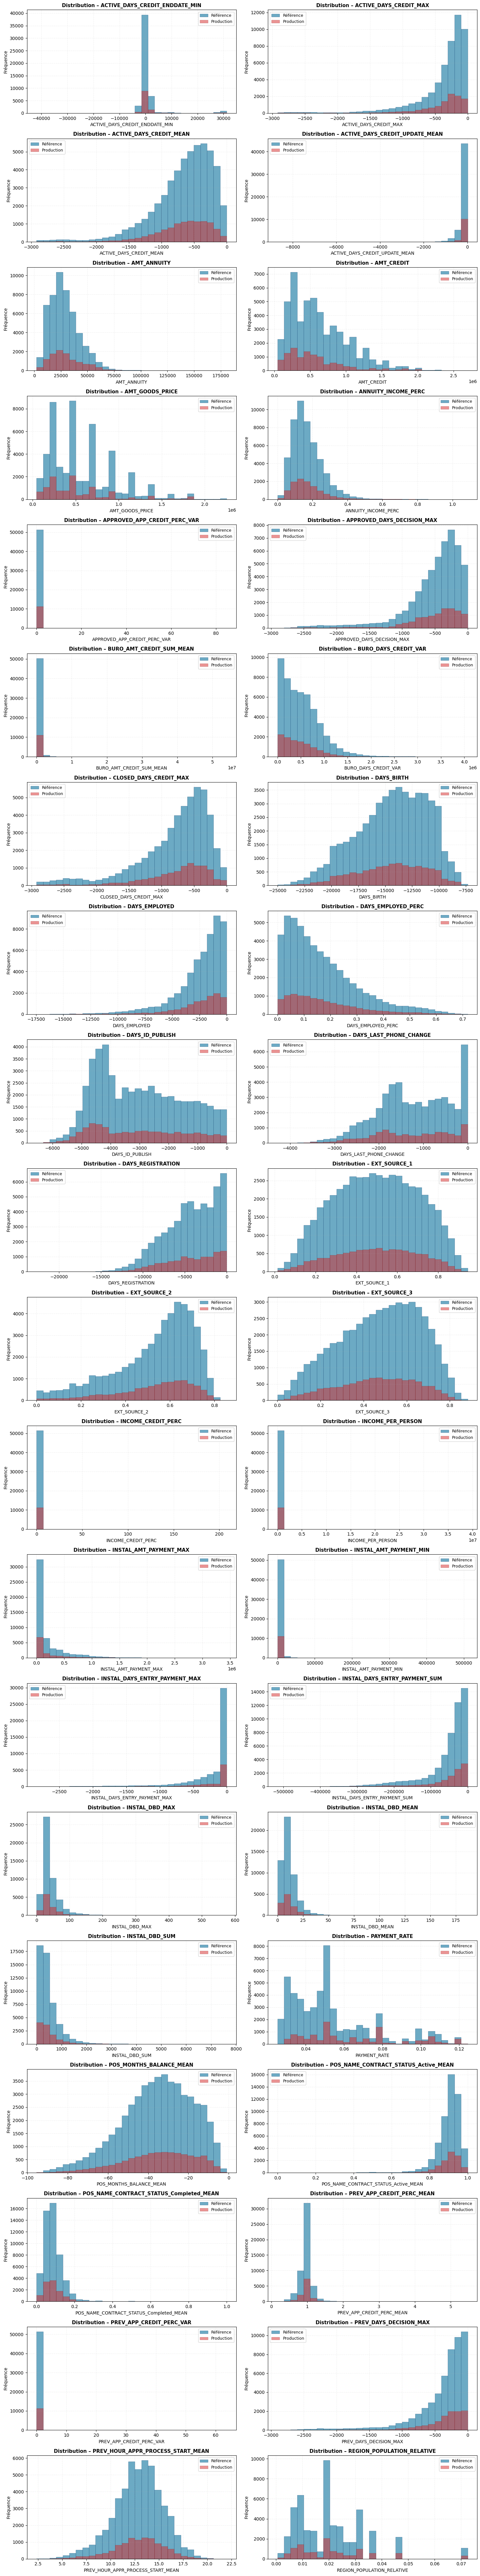

💾 Graphique sauvegardé: drift_analysis_distributions.png


In [58]:
n_features = len(features)
n_cols = 2
n_rows = math.ceil(n_features / n_cols)

fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 4 * n_rows))
axes = axes.flatten()

for idx, feature in enumerate(features):
    ax = axes[idx]

    if feature not in reference_df.columns or feature not in input_df.columns:
        ax.set_visible(False)
        continue

    ref_values = reference_df[feature].dropna()
    prod_values = input_df[feature].dropna()

    # Remove infinite values
    ref_values = ref_values[np.isfinite(ref_values)]
    prod_values = prod_values[np.isfinite(prod_values)]

    # Skip if no valid data
    if len(ref_values) == 0 and len(prod_values) == 0:
        ax.set_visible(False)
        continue

    # Déterminer les limites des bins pour une comparaison équitable
    if len(ref_values) > 0 and len(prod_values) > 0:
        combined_min = min(ref_values.min(), prod_values.min())
        combined_max = max(ref_values.max(), prod_values.max())
        bins = np.linspace(combined_min, combined_max, 30)
    elif len(ref_values) > 0:
        bins = 30
    else:
        bins = 30

    # Référence = histogramme bleu
    if len(ref_values) > 0:
        ax.hist(ref_values, bins=bins, alpha=0.7, label="Référence", 
                color='#2E86AB', edgecolor='#1A4D7A', linewidth=0.5)

    # Production = selon le nombre de valeurs
    if len(prod_values) <= 5:
        # Peu de valeurs : lignes verticales
        for i, v in enumerate(prod_values):
            if i == 0:
                ax.axvline(v, linestyle="--", linewidth=2.5, 
                          color='#D62828', label="Production", alpha=0.8)
            else:
                ax.axvline(v, linestyle="--", linewidth=2.5, 
                          color='#D62828', alpha=0.8)
    elif len(prod_values) > 0:
        # Beaucoup de valeurs : histogramme rouge
        ax.hist(prod_values, bins=bins, alpha=0.5, label="Production", 
                color='#D62828', edgecolor='#8B1A1A', linewidth=0.5)

    ax.set_title(f"Distribution – {feature}", fontsize=11, fontweight="bold")
    ax.set_xlabel(feature, fontsize=10)
    ax.set_ylabel("Fréquence", fontsize=10)
    
    # Légende avec positionnement intelligent
    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend(handles=handles, labels=labels, loc='best', fontsize=9)
    
    ax.grid(True, alpha=0.2, linestyle='--')

# Supprimer proprement les axes inutilisés
for j in range(idx + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.savefig("../output/drift_analysis_distributions.png", dpi=300, bbox_inches='tight')
plt.show()

print("💾 Graphique sauvegardé: drift_analysis_distributions.png")

## 5. Box plots comparatifs

📊 Création de 4 graphiques (10 features chacun)
✅ Graphique sauvegardé: drift_analysis_boxplots_part1.png


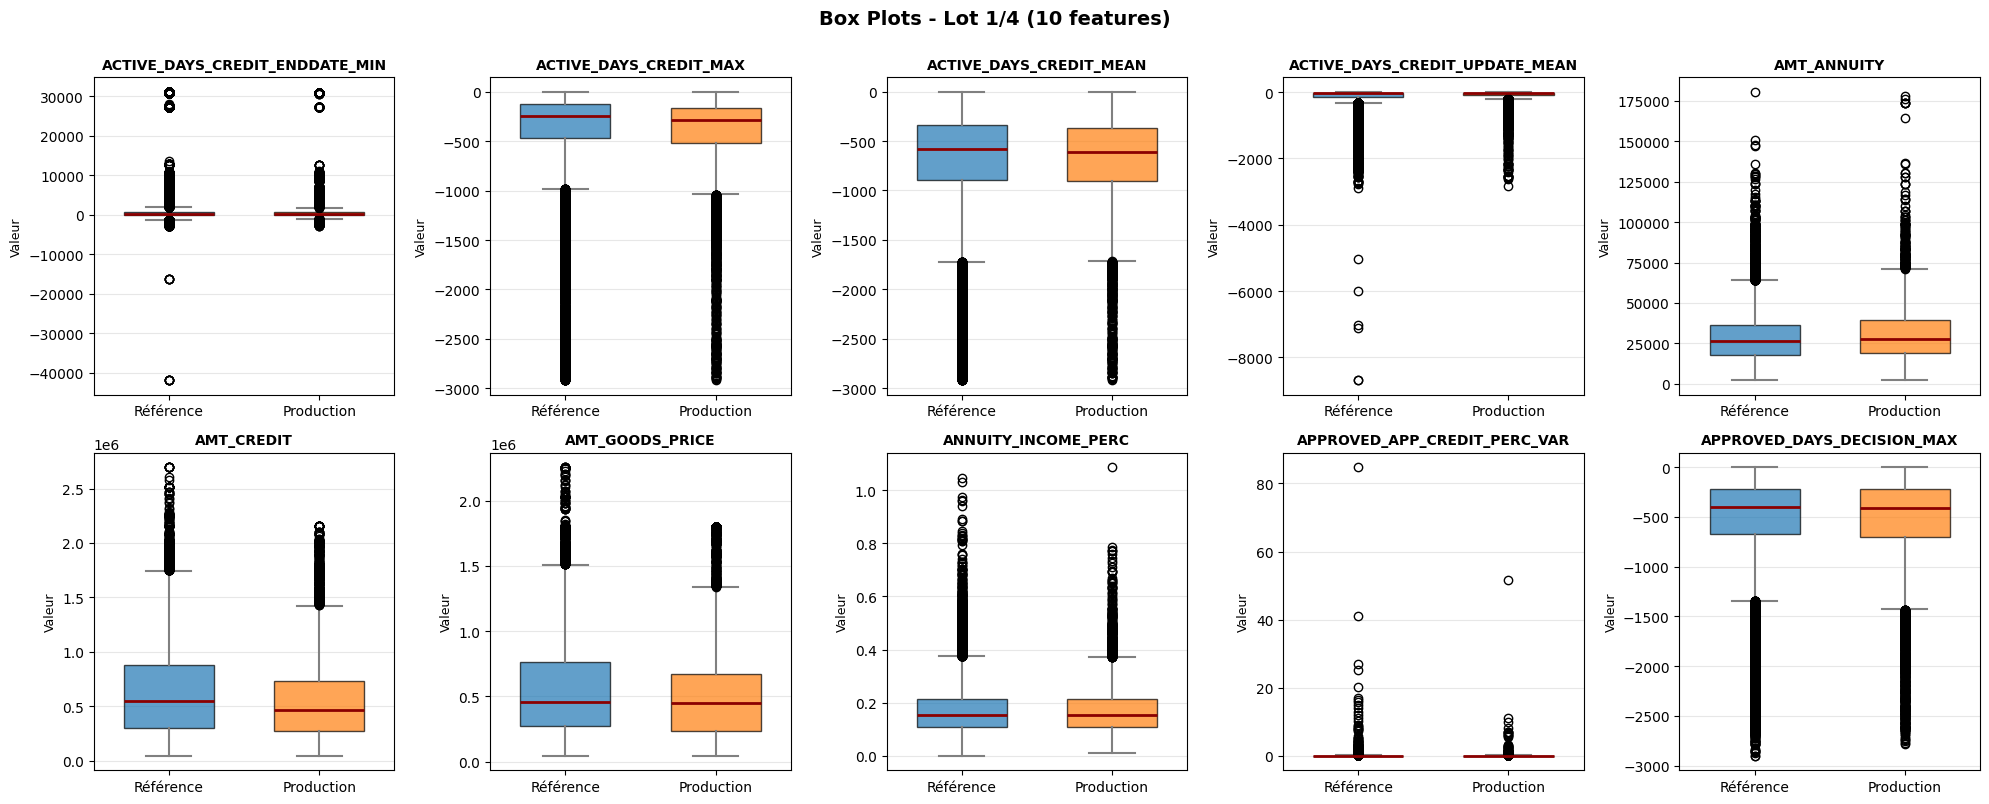

✅ Graphique sauvegardé: drift_analysis_boxplots_part2.png


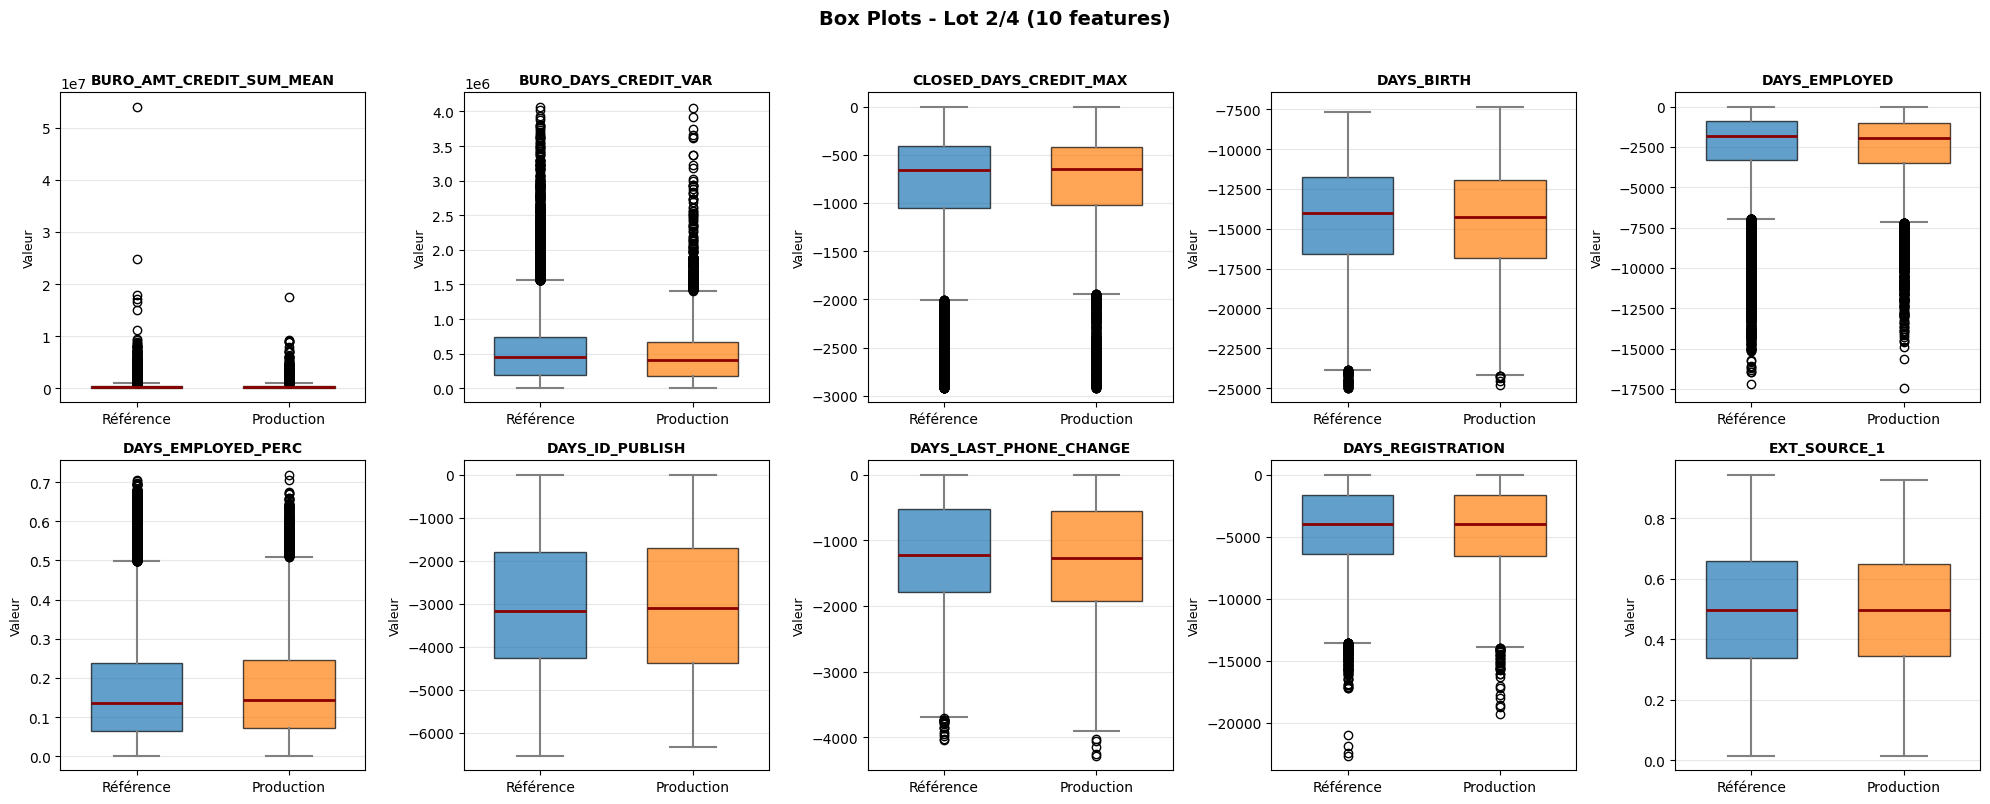

✅ Graphique sauvegardé: drift_analysis_boxplots_part3.png


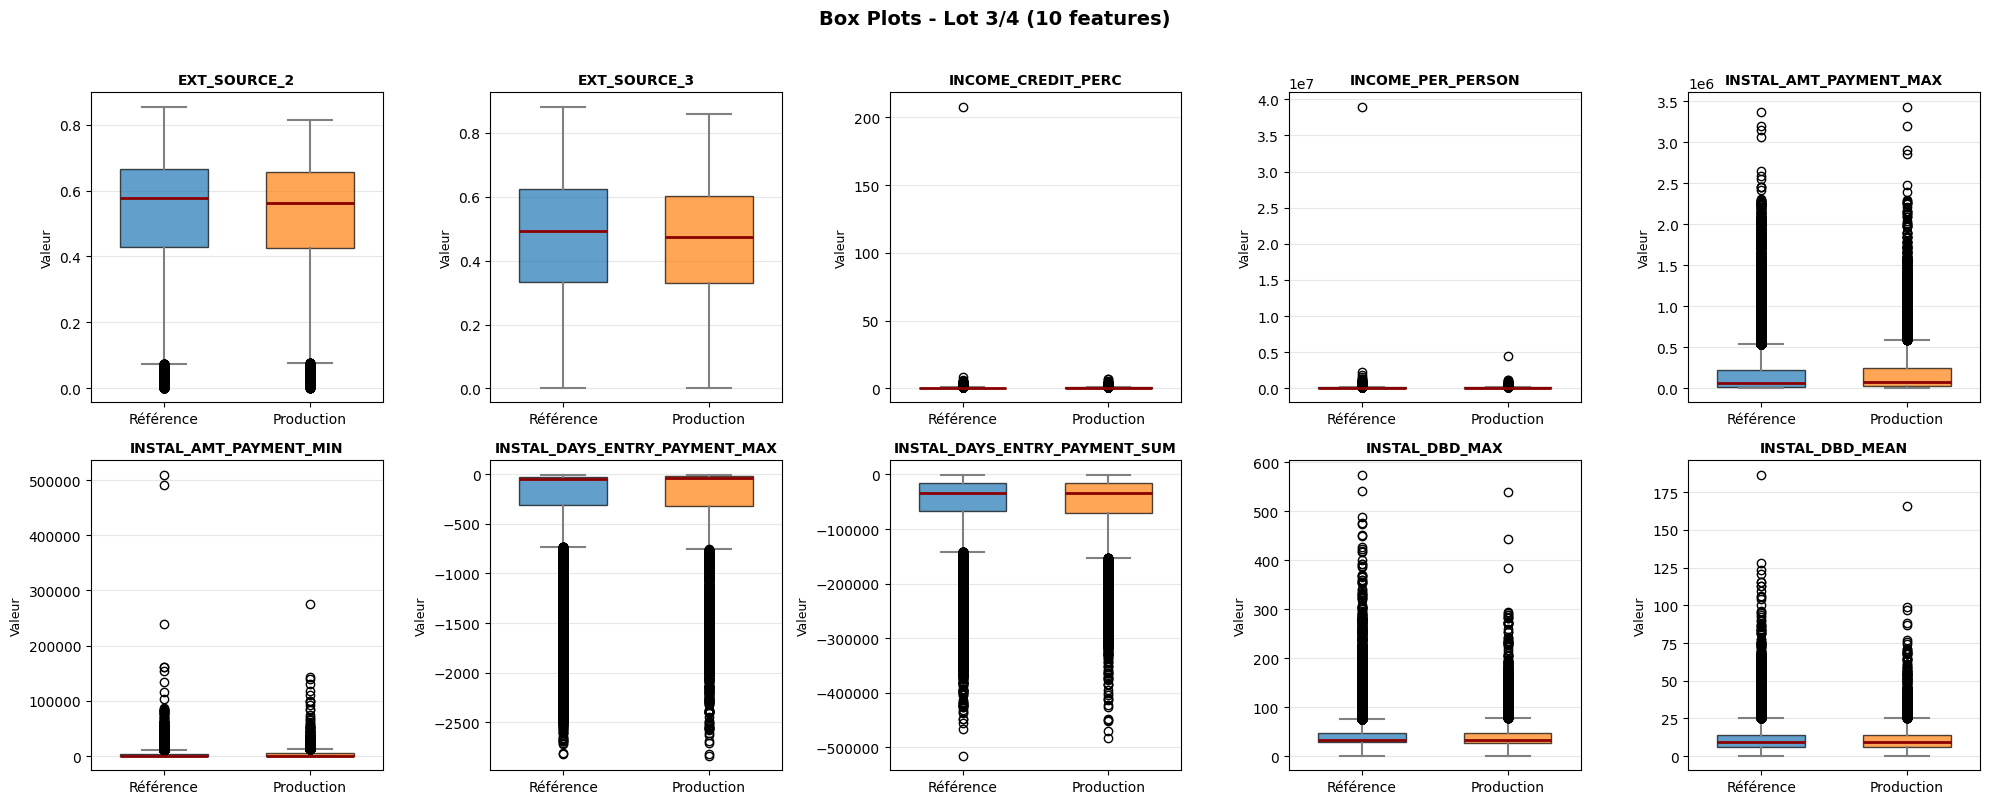

✅ Graphique sauvegardé: drift_analysis_boxplots_part4.png


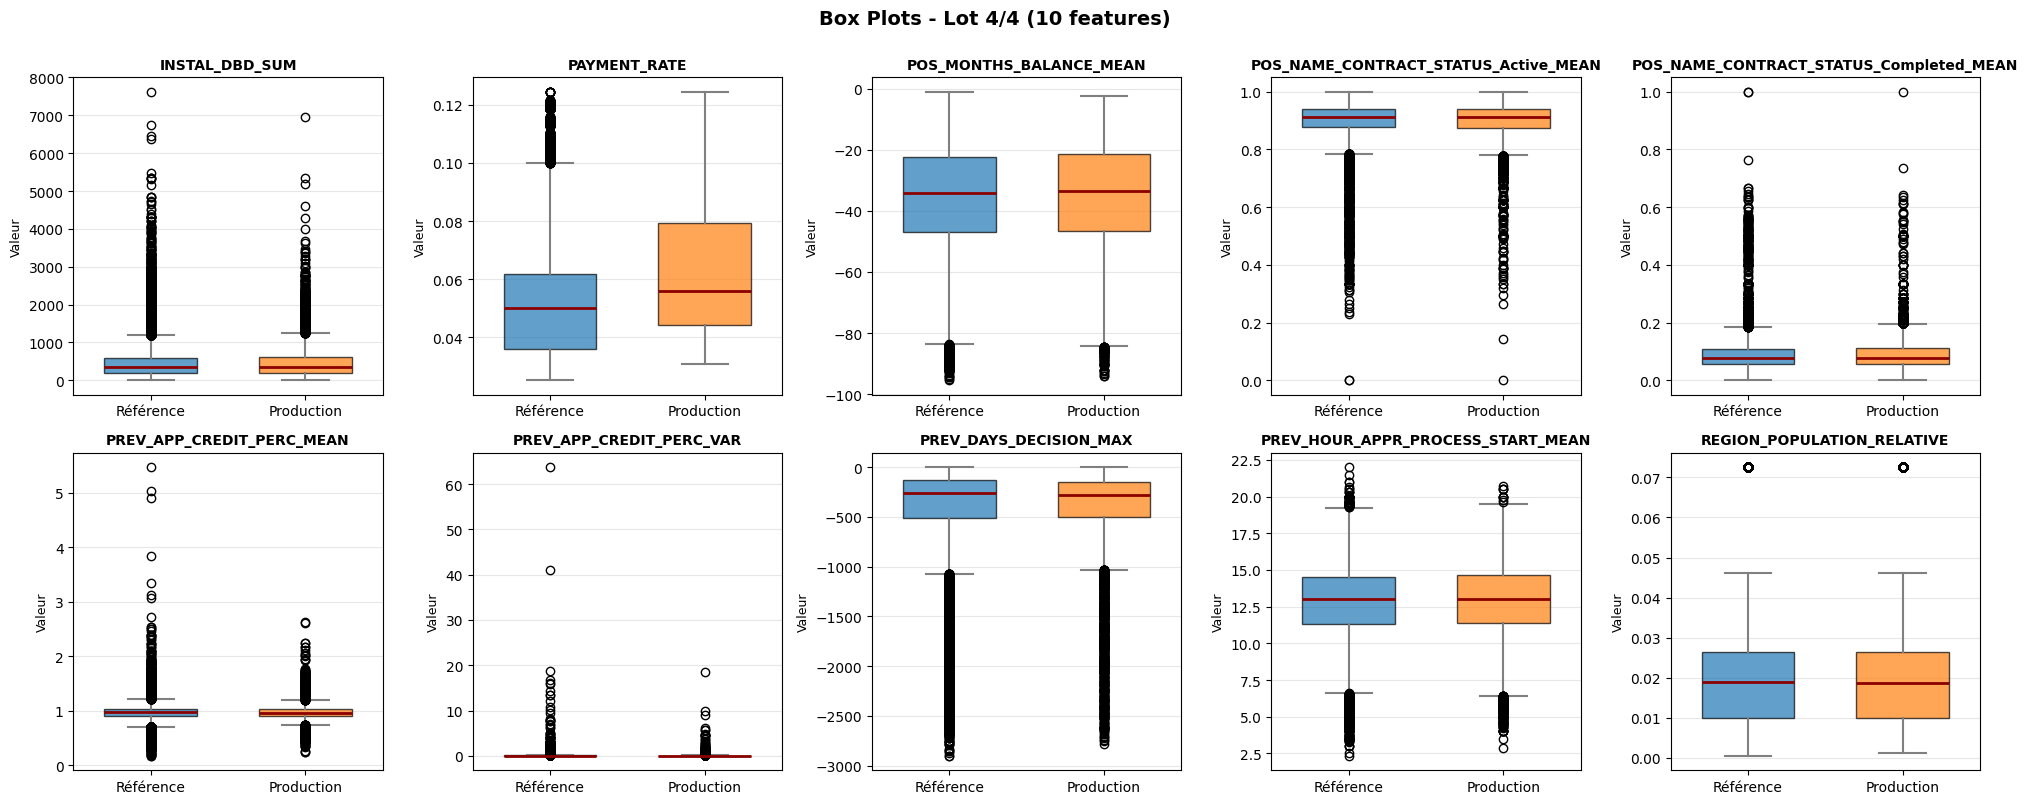


💾 Tous les graphiques ont été sauvegardés!


In [59]:
# Trier les features par ordre alphabétique
sorted_features = sorted(features)

# Diviser en chunks de 10
chunk_size = 10
chunks = [sorted_features[i:i + chunk_size] for i in range(0, len(sorted_features), chunk_size)]

print(f"📊 Création de {len(chunks)} graphiques ({chunk_size} features chacun)")

for chunk_idx, chunk in enumerate(chunks):
    fig, axes = plt.subplots(2, 5, figsize=(20, 8))
    axes = axes.flatten()
    
    for plot_idx, feature in enumerate(chunk):
        ax = axes[plot_idx]
        
        if feature in reference_df.columns and feature in input_df.columns:
            # Préparer les données (sans infinies)
            ref_data = reference_df[feature].dropna()
            ref_data = ref_data[np.isfinite(ref_data)]
            
            prod_data = input_df[feature].dropna()
            prod_data = prod_data[np.isfinite(prod_data)]
            
            if len(ref_data) > 0 and len(prod_data) > 0:
                data_to_plot = [ref_data, prod_data]
                
                bp = ax.boxplot(data_to_plot, labels=['Référence', 'Production'],
                               patch_artist=True, widths=0.6)
                
                # Colorer les boîtes
                colors = ['#1f77b4', '#ff7f0e']  # Bleu et Orange
                for patch, color in zip(bp['boxes'], colors):
                    patch.set_facecolor(color)
                    patch.set_alpha(0.7)
                
                # Styliser
                for whisker in bp['whiskers']:
                    whisker.set(linewidth=1.5, color='gray')
                for cap in bp['caps']:
                    cap.set(linewidth=1.5, color='gray')
                for median in bp['medians']:
                    median.set(linewidth=2, color='darkred')
                
                ax.set_title(feature, fontweight='bold', fontsize=10)
                ax.grid(True, alpha=0.3, axis='y')
                ax.set_ylabel('Valeur', fontsize=9)
    
    # Masquer les axes inutilisés
    for plot_idx in range(len(chunk), len(axes)):
        axes[plot_idx].set_visible(False)
    
    plt.suptitle(f'Box Plots - Lot {chunk_idx + 1}/{len(chunks)} ({len(chunk)} features)', 
                 fontsize=14, fontweight='bold', y=1.00)
    plt.tight_layout()
    
    # Sauvegarder avec numéro
    filename = f'../output/drift_analysis_boxplots_part{chunk_idx + 1}.png'
    plt.savefig(filename, dpi=300, bbox_inches='tight')
    print(f"✅ Graphique sauvegardé: drift_analysis_boxplots_part{chunk_idx + 1}.png")
    plt.show()

print("\n💾 Tous les graphiques ont été sauvegardés!")

## 6. Analyse approfondie avec Evidently

In [76]:
"""
Script de détection de drift avec Evidently (version 2025)
Simplifié et modernisé selon la dernière API
"""

print("=" * 60)
print("📊 RAPPORT DRIFT - EVIDENTLY v2025")
print("=" * 60)

# ===== PRÉPARATION DES DONNÉES =====

print(f"\n📈 Référence shape: {reference_df.shape}")
print(f"📈 Production shape: {input_df.shape}")

# ===== DÉFINITION DU SCHÉMA =====

schema = DataDefinition(
    numerical_columns=features
)

# ===== CRÉER LES DATASETS EVIDENTLY =====

input_df = input_df.drop(columns=['TARGET', 'SK_ID_CURR'], errors='ignore')

features = input_df.columns.tolist()  # Features = sans TARGET et SK_ID_CURR

report = Report(metrics=[
    DataDriftPreset(), 
])

report.run(reference_data=reference_df, current_data=input_df)
report

📊 RAPPORT DRIFT - EVIDENTLY v2025

📈 Référence shape: (51388, 42)
📈 Production shape: (11294, 40)


## 8. Export du rapport

In [77]:
# Sauvegarder les résultats
from datetime import datetime

timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
drift_df.to_csv(f'../output/drift_report_{timestamp}.csv', index=False)

print(f"\n💾 Rapport sauvegardé: drift_report_{timestamp}.csv")
print("\n✅ Analyse terminée!")


💾 Rapport sauvegardé: drift_report_20260205_154947.csv

✅ Analyse terminée!
